# ✏️ Esercizi {#sec-ex-thurstone-scaling}

In [ ]:
source("../../code/_common.R")

suppressPackageStartupMessages({
    library("rio")
    library("psych")
    library("here")
    library("gamlss")
    library("gamlss.add")
})

[1] "/Users/corradocaudek/_repositories/testing_psicologico/chapters/measurement"

## Normazione Basata sulla Regressione 

La normazione basata sulla regressione è una tecnica che consente di trasformare i punteggi grezzi di un test in punteggi normati, confrontando la performance di un individuo rispetto a una popolazione di riferimento. Questo metodo utilizza modelli statistici per stimare una relazione continua tra i punteggi del test e una variabile predittiva, come l'età.

Immaginiamo di avere un test che misura una capacità cognitiva, ad esempio il ragionamento verbale. I punteggi grezzi (quanti item un partecipante risponde correttamente) variano con l'età. Un bambino di 7 anni potrebbe ottenere un punteggio più basso rispetto a un quindicenne, ma ciò non significa necessariamente che il bambino abbia una performance peggiore: semplicemente, le abilità cognitive cambiano con l'età.

La normazione basata sulla regressione ci aiuta a interpretare i punteggi in modo equo, tenendo conto di queste differenze legate all'età.

## Tutorial

Il codice presentato in questo tutorial è una versione semplificata e adattata dell'implementazione originale proposta da @timmerman2021tutorial. I dati utilizzati sono messi a disposizione dagli autori dello studio.

Il **test IDS-2** (*Intelligence and Development Scales, Second Edition*) è uno strumento psicometrico progettato per misurare l'**intelligenza** e le **abilità di sviluppo** in bambini e adolescenti. Il test valuta un'ampia gamma di competenze cognitive, scolastiche e di sviluppo, offrendo un profilo dettagliato delle capacità del soggetto. Tra i suoi obiettivi principali vi sono la diagnosi educativa, la pianificazione di interventi e l'identificazione dei punti di forza e delle aree di miglioramento individuali.

In questo tutorial ci concentreremo sul **Sottotest 14** dell'IDS-2, denominato *Naming Antonyms* (*Denominare Contrari*), per illustrare il processo di normazione basata sulla regressione. 

Il sottotest *Naming Antonyms* è parte della scala **Verbal Reasoning** (*Ragionamento Verbale*), una componente chiave dell'**intelligenza fluida e cristallizzata** misurata dall'IDS-2. Questo sottotest valuta la capacità di generare il contrario di una parola, misurando il vocabolario, il ragionamento linguistico e la flessibilità cognitiva.

Questo specifico sottotest è particolarmente indicato per dimostrare la normazione basata sulla regressione perché i punteggi grezzi mostrano una variazione prevedibile con l'età. Tale caratteristica rende evidente l'importanza di utilizzare un modello che tenga conto delle variazioni graduali nei dati per una stima più accurata e rappresentativa.

Carichiamo il dataset di riferimento (IDS2_sample) che contiene:

- L'età dei partecipanti.
- I punteggi grezzi di un sottotest del ragionamento verbale (y14).

In [4]:
IDS2_sample <- read.table(
    here::here("data", "IDS2_sample.txt"),
    header = TRUE
    )

head(IDS2_sample)

,age,y7,y14
,<dbl>,<int>,<int>
1,10.971461,17,17
2,11.674196,20,19
3,11.444216,22,23
4,10.049315,14,14
5,14.182067,20,19
6,6.554415,11,11


### Trasformazione dei Dati

Alcuni modelli statistici non possono gestire punteggi pari a zero. Per evitare problemi, aggiungiamo un piccolo valore (es. 0.0001) a tutti i punteggi grezzi:

In [5]:
IDS2_sample$y14_a <- IDS2_sample$y14 + 0.0001

Questo non altera i risultati ma rende i calcoli più robusti.

### Costruzione del Modello

Utilizziamo un modello statistico avanzato, chiamato **BCPE (Box-Cox Power Exponential)**, che può catturare variazioni complesse nei dati. Questo modello stima come i punteggi grezzi cambiano con l'età.

Per farlo, usiamo **P-splines**, una tecnica che crea curve fluide senza imporre rigide relazioni lineari. Il modello tiene conto di:
- **Mu (μ):** La media dei punteggi.
- **Sigma (σ):** La variabilità (quanto i punteggi si disperdono).
- **Nu (ν):** La simmetria della distribuzione.
- **Tau (τ):** La "coda" della distribuzione (quanto è estesa).

In [6]:
BCPE_mod_sp <- gamlss(
    y14_a ~ pbm(age, method = "GAIC", k = log(nrow(IDS2_sample)), inter = 5, mono = "up"),
    sigma.formula = ~ pb(age, method = "GAIC", k = log(nrow(IDS2_sample)), inter = 5),
    nu.formula = ~1,
    tau.formula = ~1,
    family = BCPE,
    data = IDS2_sample,
    method = RS(1000)
)

GAMLSS-RS iteration 1: Global Deviance = 8348.078 
GAMLSS-RS iteration 2: Global Deviance = 8346.432 
GAMLSS-RS iteration 3: Global Deviance = 8346.026 
GAMLSS-RS iteration 4: Global Deviance = 8345.86 
GAMLSS-RS iteration 5: Global Deviance = 8345.847 
GAMLSS-RS iteration 6: Global Deviance = 8345.848 


#### Differenze tra il Modello BCPE e un Modello di Regressione Standard

Un modello di regressione standard (ad esempio, una regressione lineare semplice o multipla) si concentra principalmente su come la media di una variabile dipendente (ad esempio, i punteggi grezzi di un test) cambia in relazione a una o più variabili predittive (ad esempio, l'età). Il modello **Box-Cox Power Exponential (BCPE)** è molto più flessibile e sofisticato, perché descrive non solo la media, ma anche altre caratteristiche della distribuzione dei punteggi grezzi.

Vediamo nel dettaglio come il modello BCPE si differenzia da un modello di regressione standard.

---

####  Obiettivo del Modello

- **Regressione Standard:** Stima una relazione tra una variabile dipendente e una o più variabili predittive. L'obiettivo principale è prevedere la **media condizionale** della variabile dipendente per ogni valore delle predittive.
  - Ad esempio: "Come cambia il punteggio medio del test con l'aumentare dell'età?"

- **Modello BCPE:** Non si limita a stimare la media, ma descrive l'intera distribuzione dei punteggi grezzi in funzione dell'età. Stima quattro parametri:

  1. **Mu (μ):** La media dei punteggi grezzi (equivalente all'obiettivo della regressione standard).
  2. **Sigma (σ):** La variabilità dei punteggi (dispersione).
  3. **Nu (ν):** La simmetria della distribuzione (se la distribuzione è simmetrica o asimmetrica).
  4. **Tau (τ):** L'estensione delle code della distribuzione (quanto sono probabili valori estremi).

#### Caratteristiche della Distribuzione

- **Regressione Standard:** Presuppone che i dati seguano una distribuzione normale con:

  - Una varianza costante (omoschedasticità).
  - Una distribuzione simmetrica.
  - Code "standard" (come nella distribuzione normale).

- **Modello BCPE:** Permette alla distribuzione di:

  - Avere una varianza che cambia con l'età (**eteroschedasticità**).
  - Essere asimmetrica (ad esempio, con più punteggi bassi che alti o viceversa).
  - Avere code più estese o più strette rispetto a quelle di una normale.

Questo è particolarmente utile nei test psicologici, dove la varianza, la simmetria e le code possono cambiare in modo complesso con l'età o altre variabili.

#### Relazione Tra Punteggi e Predittori

- **Regressione Standard:** La relazione tra la variabile dipendente e le predittive è solitamente definita da una funzione lineare o polinomiale, che è rigida e può non adattarsi bene a dati complessi.

- **Modello BCPE con P-Splines:** Utilizza le **P-splines**, una tecnica che consente di creare curve fluide senza imporre una forma rigida alla relazione. Le P-splines dividono la variabile predittiva (ad esempio, l'età) in intervalli e stimano una curva continua che si adatta ai dati, permettendo cambiamenti graduali e non lineari.

#### Uso di Più Parametri

- **Regressione Standard:** Stima solo i parametri per il modello della media (es. i coefficienti di regressione).

- **BCPE:** Stima parametri separati per la media (μ), la dispersione (σ), la simmetria (ν) e le code (τ), permettendo di descrivere l'intera distribuzione dei punteggi.

#### Applicazioni Pratiche

- **Regressione Standard:** Adatta per dati semplici dove interessa principalmente come cambia la media rispetto a una predittiva.

- **Modello BCPE:** Ideale per dati complessi, come punteggi psicometrici, dove:
  - I valori estremi (code) sono importanti.
  - La variabilità cambia con la predittiva (ad esempio, i punteggi diventano più vari con l'aumentare dell'età).
  - La distribuzione non è simmetrica.

---

Nel modello BCPE specificato:

1. **Media (μ):** Relazione stimata con P-splines (non lineare):
   ```r
   y14_a ~ pbm(age, method = "GAIC", k = log(nrow(IDS2_sample)), inter = 5, mono = "up")
   ```

2. **Variabilità (σ):** Anche questa varia con l'età, stimata con P-splines:
   ```r
   sigma.formula = ~ pb(age, method = "GAIC", k = log(nrow(IDS2_sample)), inter = 5)
   ```

3. **Simmetria (ν) e Coda (τ):** In questo esempio, sono assunti costanti per semplicità:
   ```r
   nu.formula = ~ 1,
   tau.formula = ~ 1
   ```

4. **Famiglia BCPE:** Specifica che i dati seguono la distribuzione Box-Cox Power Exponential, flessibile per adattarsi ai dati osservati:
   ```r
   family = BCPE
   ```

---

In conclusione, il modello BCPE è più complesso di una regressione standard, ma è anche molto più potente. Permette di:

- Descrivere come i punteggi cambiano non solo in media, ma anche nella variabilità, simmetria e code.
- Adattarsi a dati complessi grazie alla flessibilità delle P-splines.

Questo lo rende uno strumento ideale per la normazione basata sulla regressione in contesti psicologici.

### Predizione per Ogni Età

Per comprendere come i punteggi del test variano con l'età, stimiamo i parametri del modello (μ, σ, ν, τ) per una gamma continua di età (ad esempio, dai 5 ai 21 anni). Questi parametri descrivono l'intera distribuzione dei punteggi grezzi per ogni età, permettendoci di costruire curve continue.

In [11]:
# Creazione di una gamma di età da 5 a 21 anni
pop_age <- data.frame(age = seq(5, 21, length.out = 1000))
# Predizione dei parametri distribuzionali per ogni età
pred_distr <- predictAll(BCPE_mod_sp, newdata = pop_age, type = "response")

Con questa predizione, otteniamo per ciascuna età i seguenti parametri:

- μ (media): Il punteggio medio previsto.
- σ (deviazione standard): La variabilità dei punteggi.
- ν (asimmetria): Indica se la distribuzione è sbilanciata verso destra o sinistra.
- τ (code): Indica quanto i punteggi estremi sono frequenti.

### Calcolo dei Percentili

Una volta stimati i parametri per ogni età, possiamo calcolare i percentili per una gamma di punteggi grezzi (ad esempio, da 0 a 34). I percentili ci dicono come un punteggio si posiziona rispetto alla popolazione.

In [12]:
# Definizione dell'intervallo di punteggi grezzi
Min_score <- 0.0001
Max_score <- 34.0001
step_size <- 1

# Matrice per i percentili (righe = età, colonne = punteggi grezzi)
CDF_matrix <- matrix(NA, nrow = nrow(pop_age), ncol = 35) # 35 punteggi grezzi possibili

# Calcolo della distribuzione cumulativa per ogni età
for (i in 1:nrow(pop_age)) {
    CDF_matrix[i, ] <- pBCPE(
        seq(from = 0.0001, to = 34.0001, by = 1),
        mu = pred_distr$mu[i],
        sigma = pred_distr$sigma[i],
        nu = pred_distr$nu[i],
        tau = pred_distr$tau[i],
        lower.tail = TRUE
    )
}

Questa matrice contiene i percentili per ogni combinazione di età e punteggio grezzo.

### Trasformazione in Punteggi Z

I percentili vengono poi trasformati in punteggi Z, che indicano quanto un punteggio si discosta dalla media della popolazione (in unità di deviazione standard). Ad esempio:

- uno Z = 0 rappresenta la media;
- uno Z = 1.5 significa che il punteggio è 1.5 deviazioni standard sopra la media.

In [13]:
# Trasformazione dei percentili in punteggi Z
z_matrix14 <- qnorm(CDF_matrix)

# Limitazione dei valori Z al range [-3, +3]
z_matrix14 <- apply(z_matrix14, 1, function(x) ifelse(x > 3, 3, ifelse(x < -3, -3, x)))

# Trasposizione della matrice per allineare righe (età) e colonne (punteggi grezzi)
z_matrix14 <- t(z_matrix14) # Ora z_matrix14 avrà dimensioni [1000, 35]

### Visualizzazione dei Punteggi Z

Plottiamo i punteggi Z rispetto all'età. Ogni linea rappresenta un punteggio grezzo specifico e mostra come il relativo Z-score varia con l'età.

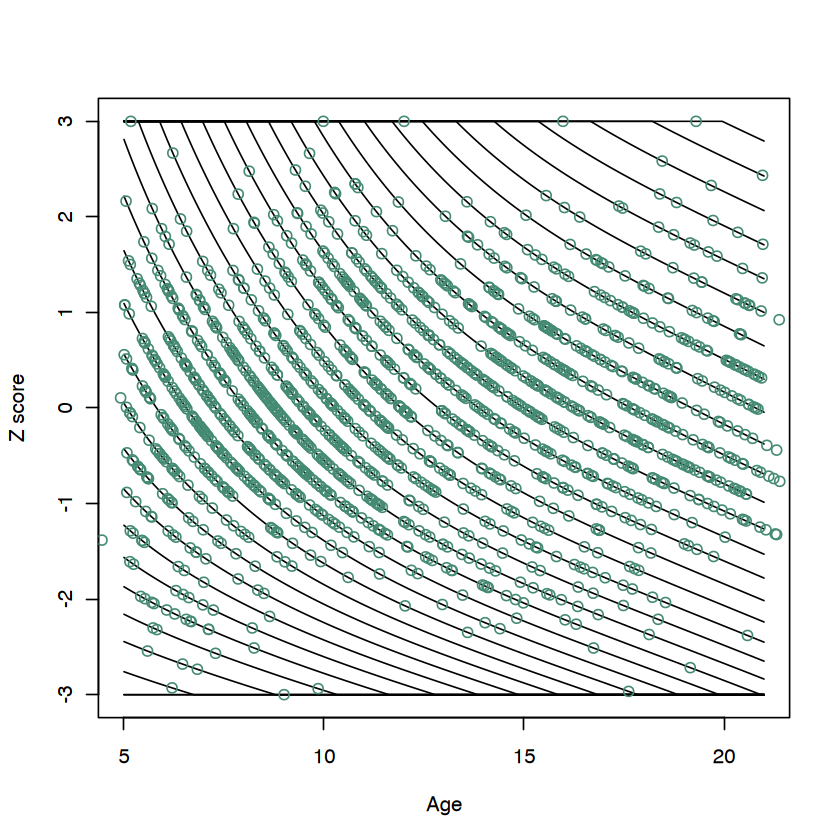

In [ ]:
# Grafico delle curve Z rispetto all'età
plot(z_matrix14[, 1], x = pop_age[, "age"], ylim = c(-3, 3), ylab = "Z score", xlab = "Age", type = "l")
for (i in 2:ncol(z_matrix14)) {
    lines(z_matrix14[, i], x = pop_age[, "age"])
}

# Per confrontare i risultati del modello con i dati reali, calcoliamo i punteggi Z per ogni 
# partecipante del campione normativo.
CDF_sample <- rep(NA, times = nrow(IDS2_sample))
for (i in 1:nrow(IDS2_sample)) {
    CDF_sample[i] <- pBCPE(
        IDS2_sample$y14_a[i],
        mu = BCPE_mod_sp$mu.fv[i],
        sigma = BCPE_mod_sp$sigma.fv[i],
        nu = BCPE_mod_sp$nu.fv[i],
        tau = BCPE_mod_sp$tau.fv[i],
        lower.tail = TRUE
    )
}

# Trasformazione in punteggi Z
z_sample14 <- ifelse(qnorm(CDF_sample) > 3, 3, ifelse(qnorm(CDF_sample) < -3, -3, qnorm(CDF_sample)))

# Aggiunta dei dati osservati al grafico
points(z_sample14, x = IDS2_sample$age, col = "aquamarine4", pch = 1)

### Interpretazione

- Punteggio Z = 1.5: Il partecipante si trova circa all’85° percentile, ovvero ha una performance migliore rispetto all’85% della popolazione.
- Punteggio Z = -2: Il partecipante si colloca al 2° percentile, indicando una performance significativamente inferiore alla media.

### Vantaggi della Normazione Basata sulla Regressione

- Continuità: Ogni età ha un valore stimato unico, senza salti artificiali tra fasce di età.
- Precisione: Le curve catturano le variazioni graduali nella popolazione.
- Adattabilità: Si adatta a distribuzioni complesse (non lineari, asimmetriche, con code estese).

Questa metodologia consente agli psicologi di interpretare i punteggi del test in modo equo e accurato, tenendo conto delle differenze nella popolazione di riferimento.

### Grafico delle Curve Centili 

La funzione `centiles.fan` del pacchetto `gamlss` calcola automaticamente le curve centili utilizzando i parametri stimati dal modello, rendendo facile visualizzare le relazioni tra punteggi grezzi, età e percentili.

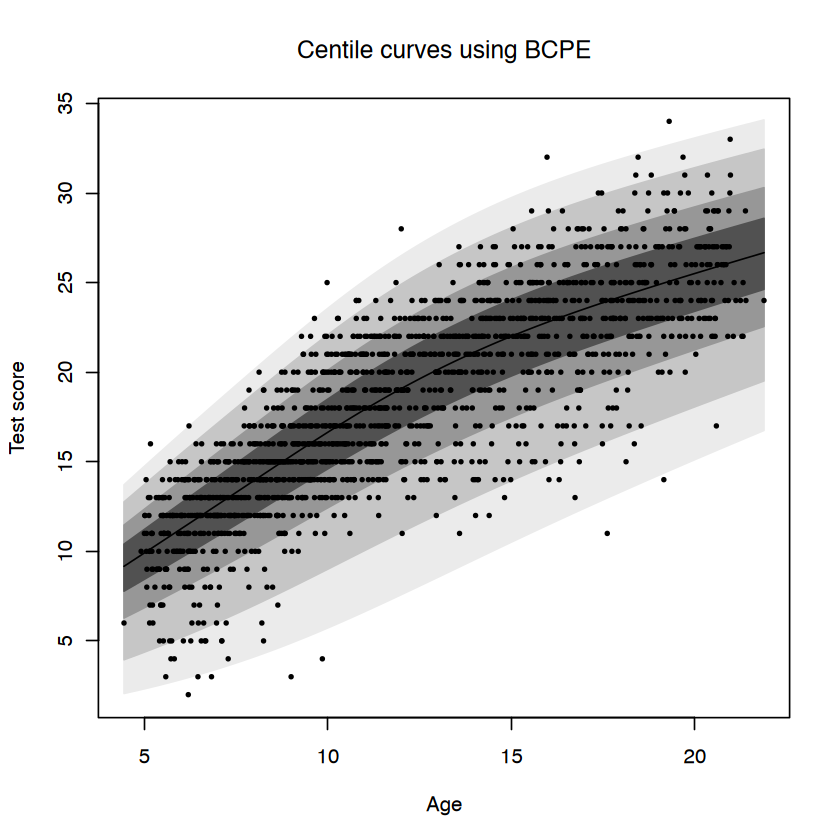

In [23]:
# Aggiunta di curve centili al plot
centiles.fan(
    BCPE_mod_sp,
    xvar = IDS2_sample$age,
    points = TRUE,
    colors = "gray",
    col = "black",
    pch = 16,
    ylab = "Test score",
    xlab = "Age"
)

Le curve centili mostrano le soglie per diversi percentili in base ai dati normativi. Ogni curva indica il valore del punteggio grezzo che corrisponde a un determinato percentile per una data età.

Nel grafico delle curve centili, le quattro regioni attorno alla mediana (il **50° percentile**) rappresentano intervalli percentili specifici. Le intensità di grigio diverse riflettono il grado di **normalità** o **tipicità** del punteggio rispetto alla popolazione di riferimento. Più una regione è vicina alla mediana, più i punteggi in quella fascia sono considerati "tipici". Ecco come si interpretano le regioni:

#### Regione più scura (vicina alla mediana): 25° - 75° percentile

- Questa regione rappresenta i **punteggi tipici** della popolazione.
- Circa il **50%** dei partecipanti si trova in questa fascia (dal 25% al 75% della distribuzione).
- **Interpretazione pratica:**  
  Un punteggio all'interno di questa regione indica una performance normale per quell'età. Ad esempio:
  - Un punteggio nel **50° percentile** (linea centrale della regione) è esattamente nella media.
  - Punteggi vicini al 25° o al 75° percentile sono ancora normali, ma più vicini ai limiti della variabilità tipica.

#### Seconda regione (più chiara): 10° - 90° percentile

- Questa regione include punteggi **ampiamente tipici**, coprendo circa l'**80%** della popolazione.
- I punteggi qui sono meno comuni rispetto alla fascia 25°-75°, ma rientrano comunque in un range "non estremo".
- **Interpretazione pratica:**  
  - Un punteggio in questa regione può indicare una leggera deviazione dalla norma, ma non è considerato problematico.  
  - Ad esempio, un punteggio nel **10° percentile** è basso rispetto alla maggior parte della popolazione, ma non è raro.

#### Terza regione (ancora più chiara): 2° - 98° percentile

- Questa regione copre i **valori estremi non eccezionali**, includendo circa il **96%** della popolazione.
- I punteggi qui sono considerati **insoliti**, ma non necessariamente indicativi di un'anomalia significativa.

#### Regione più chiara (esterna): 0.4° - 99.6° percentile

- Questa regione rappresenta i **valori estremi** della distribuzione, includendo circa il **99.2%** della popolazione.
- I punteggi in questa fascia sono **molto rari** e spesso considerati **anomali**.
- Interpretazione pratica:
  - Un punteggio al di sotto del **0.4° percentile** o al di sopra del **99.6° percentile** è eccezionalmente basso o alto e potrebbe indicare una condizione atipica, sia in senso negativo che positivo.

\

| Regione          | Intervallo Percentile | Popolazione Inclusa | Interpretazione         |
|------------------|-----------------------|---------------------|-------------------------|
| **Più scura**    | 25° - 75°             | 50%                 | Performance tipica      |
| **Seconda**      | 10° - 90°             | 80%                 | Ampiamente tipica       |
| **Terza**        | 2° - 98°              | 96%                 | Insolita ma non estrema |
| **Più chiara**   | 0.4° - 99.6°          | 99.2%               | Valori estremi          |

\

- I punteggi vicini alla mediana o all'interno del **25°-75° percentile** sono i più comuni e indicano normalità.
- I punteggi che cadono nelle regioni più chiare potrebbero richiedere ulteriori indagini, soprattutto se sono nella fascia **0.4°-2° percentile** (valori estremamente bassi) o **98°-99.6° percentile** (valori estremamente alti).

Questo tipo di visualizzazione aiuta a collocare rapidamente un punteggio individuale rispetto alla distribuzione della popolazione e a identificare possibili deviazioni significative.

#### La Funzione `centiles.fan`

La funzione `centiles.fan` è un'utility di `gamlss` che calcola e plotta automaticamente queste curve centili in base a un modello stimato.

1. **`BCPE_mod_sp`:** 
   Questo è il modello stimato, che definisce come i punteggi del test sono distribuiti in funzione dell'età. La funzione usa i parametri del modello (μ, σ, ν, τ) per calcolare le curve centili.

2. **`xvar = IDS2_sample$age`:**
   Specifica che l'età è la variabile sull'asse X. Questo consente di tracciare le curve centili rispetto all'età.

In [21]:
sessionInfo()

R version 4.3.2 (2023-10-31)
Platform: aarch64-apple-darwin20 (64-bit)
Running under: macOS Sonoma 14.3.1

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRblas.0.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRlapack.dylib;  LAPACK version 3.11.0

locale:
[1] C

time zone: Europe/Rome
tzcode source: internal

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] rio_1.0.1         ggokabeito_0.1.0  viridis_0.6.5     viridisLite_0.4.2
 [5] ggpubr_0.6.0      ggExtra_0.10.1    bayesplot_1.11.0  gridExtra_2.3    
 [9] patchwork_1.2.0   semTools_0.5-6    semPlot_1.1.6     lavaan_0.6-17    
[13] psych_2.4.1       scales_1.3.0      markdown_1.12     knitr_1.45       
[17] lubridate_1.9.3   forcats_1.0.0     stringr_1.5.1     dplyr_1.1.4      
[21] purrr_1.0.2       readr_2.1.5       tidyr_1.3.1       tibble_3.2.1     
[25] ggplot2_